CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [ ]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1
batch_size = 128
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


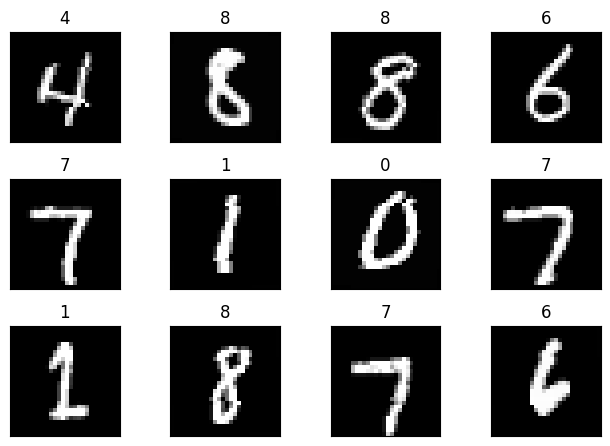

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 10, 3),
            nn.BatchNorm2d(10),
            nn.Dropout(0.025)
        )
        self.gap = nn.AvgPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.flatten().view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

| Layer                         | Rin  | Rout | Jin  | Jout |
|-------------------------------|-------|------|------|------|
| **Input Image (28x28)**       | 1     | 1    | 1    | 1    |
| **Conv Block 1**              |       |      |      |      |
| Conv2d(1, 8, K=3, P=0, S=1)   | 1     | 3    | 1    | 1    |
| Conv2d(8, 8, K=3, P=0, S=1)   | 3     | 5    | 1    | 1    |
| MaxPool2d(K=2, S=2)           | 5     | 6    | 1    | 2    |
| **Conv Block 2**              |       |      |      |      |
| Conv2d(8, 16, K=3, P=0, S=1)  | 6     | 10   | 2    | 2    |
| Conv2d(16, 16, K=3, P=0, S=1) | 10    | 14   | 2    | 2    |
| MaxPool2d(K=2, S=2)           | 14    | 16   | 2    | 4    |
| **Conv Block 3**              |       |      |      |      |
| Conv2d(16, 10, K=3, P=0, S=1) | 16    | 24   | 4    | 4    |
| AvgPool2d(K=2, S=2)           | 24    | 26   | 4    | 8    |
| **GAP (Global Avg Pool)**     | 26    | Full | 8    | -    |


In [ ]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             584
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
         MaxPool2d-7            [-1, 8, 12, 12]               0
              ReLU-8            [-1, 8, 12, 12]               0
           Dropout-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,168
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
           Conv2d-13             [-1, 16, 8, 8]           2,320
             ReLU-14             [-1, 1

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred,  target.squeeze())
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Train: Loss=0.2173 Batch_id=468 Accuracy=92.27: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]


Test set: Average loss: 0.0009, Accuracy: 9817/10000 (98.17%)

Epoch 2


Train: Loss=0.1284 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Test set: Average loss: 0.0005, Accuracy: 9878/10000 (98.78%)

Epoch 3


Train: Loss=0.0620 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]


Test set: Average loss: 0.0004, Accuracy: 9905/10000 (99.05%)

Epoch 4


Train: Loss=0.0646 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]


Test set: Average loss: 0.0004, Accuracy: 9905/10000 (99.05%)

Epoch 5


Train: Loss=0.1464 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:36<00:00, 12.70it/s]


Test set: Average loss: 0.0003, Accuracy: 9917/10000 (99.17%)

Epoch 6


Train: Loss=0.2115 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s]


Test set: Average loss: 0.0003, Accuracy: 9910/10000 (99.10%)

Epoch 7


Train: Loss=0.0601 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:36<00:00, 12.83it/s]


Test set: Average loss: 0.0003, Accuracy: 9916/10000 (99.16%)

Epoch 8


Train: Loss=0.0798 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]


Test set: Average loss: 0.0003, Accuracy: 9916/10000 (99.16%)

Epoch 9


Train: Loss=0.0781 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]


Test set: Average loss: 0.0003, Accuracy: 9914/10000 (99.14%)

Epoch 10


Train: Loss=0.0580 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:37<00:00, 12.43it/s]


Test set: Average loss: 0.0003, Accuracy: 9909/10000 (99.09%)

Epoch 11


Train: Loss=0.1371 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


Test set: Average loss: 0.0003, Accuracy: 9916/10000 (99.16%)

Epoch 12


Train: Loss=0.0701 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:37<00:00, 12.59it/s]


Test set: Average loss: 0.0004, Accuracy: 9903/10000 (99.03%)

Epoch 13


Train: Loss=0.0466 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s]


Test set: Average loss: 0.0003, Accuracy: 9915/10000 (99.15%)

Epoch 14


Train: Loss=0.0889 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]


Test set: Average loss: 0.0003, Accuracy: 9915/10000 (99.15%)

Epoch 15


Train: Loss=0.0793 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:36<00:00, 12.84it/s]


Test set: Average loss: 0.0003, Accuracy: 9915/10000 (99.15%)

